In [1]:
from ibl_pipeline.analyses import behavior
from ibl_pipeline import behavior as behavior_ingest
from ibl_pipeline import subject, acquisition
from ibl_pipeline.utils import psychofit as psy
import plotting_utils as putils
import numpy as np
import datetime
import datajoint as dj
import statsmodels.stats.proportion as smp
import plotly
import plotly.graph_objs as go
import seaborn as sns 
import pandas as pd
import json
plotly.offline.init_notebook_mode(connected=True)

Connecting shan@datajoint.internationalbrainlab.org:3306
Connected to https://alyx.internationalbrainlab.org as vathes


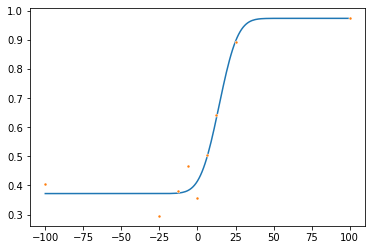

In [2]:
# Regular plotting
key = {'lab_name': 'cortexlab',
   'subject_nickname': 'MW003',
   'session_start_time': datetime.datetime(2019, 1, 14, 17, 24, 20)}
session = behavior.PsychResults & key
contrasts, prob_right, threshold, bias, lapse_low, lapse_high, n_trials, n_trials_right = session.fetch1(
    'signed_contrasts', 'prob_choose_right', 'threshold', 'bias', 'lapse_low', 'lapse_high', 'n_trials_stim', 'n_trials_stim_right')
pars = [bias, threshold, lapse_low, lapse_high]
contrasts = contrasts * 100
contrasts_fit = np.arange(-100, 100)
prob_right_fit = psy.erf_psycho_2gammas(pars, contrasts_fit)
sns.lineplot(contrasts_fit, prob_right_fit)
sns.lineplot(x=contrasts, y=prob_right, err_style="bars", linewidth=0, linestyle='None', mew=0.5,
        marker='.', ci=68)

In [4]:
subj_uuid = (subject.Subject & 'subject_nickname="IBL_13"').fetch1('subject_uuid')
key = {'subject_uuid': subj_uuid,
   'session_start_time': datetime.datetime(2019, 4, 8, 10, 42, 5)}
sessions = behavior.PsychResultsBlock & key

data_mean = []
data_errorbar = []
data_fit = []
data_text = []

for session in sessions.fetch('KEY'):
    contrasts, prob_right, prob_left, threshold, bias, lapse_low, lapse_high, n_trials, n_trials_right = \
        (sessions & session).fetch1(
            'signed_contrasts', 'prob_choose_right', 'prob_left', 'threshold', 'bias', 
            'lapse_low', 'lapse_high', 'n_trials_stim', 'n_trials_stim_right')
    pars = [bias, threshold, lapse_low, lapse_high]
    contrasts = contrasts * 100
    contrasts_fit = np.arange(-100, 100)
    prob_right_fit = psy.erf_psycho_2gammas(pars, contrasts_fit)
    ci = smp.proportion_confint(
    n_trials_right, n_trials, alpha=0.32, method='normal') - prob_right
    
    curve_color, error_color = putils.get_color(prob_left, 0.3)

    behavior_data = go.Scatter(
        x=contrasts.tolist(),
        y=prob_right.tolist(),
        marker=dict(
            size=6,
            color=curve_color,
            line=dict(
                color='white',
                width=1
            )
        ),
        mode='markers',
        name=f'p_left = {prob_left}, data with 68% CI'
    )
    
    behavior_errorbar = go.Scatter(
        x = contrasts.tolist(),
        y = prob_right.tolist(),
        error_y = dict(
            type='data',
            array=ci[0].tolist(),
            arrayminus=np.negative(ci[1]).tolist(),
            visible=True,
            color=error_color
        ),
        marker=dict(
            size=6,
        ),
        mode='none',
        showlegend=False
    )

    behavior_fit = go.Scatter(
        x=contrasts_fit.tolist(),
        y=prob_right_fit.tolist(),
        name=f'p_left = {prob_left} model fits',
        marker=dict(color=curve_color)
    )
    

    data_mean.append(behavior_data)
    data_errorbar.append(behavior_errorbar)
    data_fit.append(behavior_fit)
    
layout = go.Layout(
    width=630,
    height=350,
    title=dict(
        text='Psychometric Curve',
        x=0.25,
        y=0.85
    ),
    xaxis=dict(
        title='Contrast (%)'), 
    yaxis=dict(
        title='Probability choosing right',
        range=[-0.05, 1.05]),
    template=dict(
        layout=dict(
            plot_bgcolor="white"
        )
    )
)

data = data_errorbar
for element in data_fit:
    data.append(element)

for element in data_mean:
    data.append(element)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [3]:
f = open("session_psych_results.json","w")
s = json.dumps(fig.to_plotly_json())
f.write(s)
f.close()